<a href="https://colab.research.google.com/github/AryanMohanty0/Cyclone-Abnormality/blob/main/algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install panda numpy scikit-learn matplotlib scipy ruptures

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.0 MB/s eta 0:00:00
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=b0d35ccbfec5786e32113e21f5788bf24f33580a38ccd0ea37d05bb95eb9b1fa
  Stored in directory: /root/.cache/pip/wheels/df/5c/39/36f8dae25a1e88d6ec4411dec4a143781e64fdff6897758eec
Successfully built panda


In [2]:
#1)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.ensemble import IsolationForest
import ruptures as rpt
import os
import argparse
from datetime import timedelta

In [3]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/data (5) (1) (1) (1) (1)(internship-data-1).csv'
if os.path.exists(PATH):
    print("File exists")
    df = pd.read_csv(PATH)
    print("csv file loaded successfully")
else:
    print("File does not exist")


csv_path = '/content/drive/MyDrive/data (5) (1) (1) (1) (1)(internship-data-1).csv'
outdir =  '/content/drive/MyDrive/algo8_output'

Mounted at /content/drive
File exists
csv file loaded successfully


In [4]:
#3)
os.makedirs(outdir, exist_ok = True)  #os.makedirs() would throw an error (FileExistsError) if the folder already exists.
                                      #exist_ok=True → "It’s okay if the folder already exists, don’t raise an error."

In [5]:
#4)
df = pd.read_csv(csv_path, low_memory=False) #low_memory = False ensures Pandas will read the whole column before deciding the type.
                                            #This uses a bit more memory, but ensures more accurate and consistent dtype detection.
                                            #low_memory = True is default uses less memory so starts guessing datatypes of column without reading it entirely

In [6]:
#5)
df['time'] = pd.to_datetime(df['time'], errors='coerce',infer_datetime_format=True)

/tmp/ipython-input-227100992.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['time'] = pd.to_datetime(df['time'], errors='coerce',infer_datetime_format=True)


In [7]:
#6)
value_cols = [c for c in df.columns if c != 'time']
for c in value_cols:
  df[c] = pd.to_numeric(
      df[c].astype(str).str.replace(',','').str.strip(),
      errors='coerce'
  )

In [8]:
#7)
df = df.dropna(subset=['time']).sort_values('time').set_index('time')

In [9]:
#8)
window = 12
df_5m = df.resample('5min').mean()
df_5m = df_5m.interpolate(method='time',limit=int(window),limit_direction='both')
print("data is prepared after resampling:", df_5m.shape)
df_5m.head()

data is prepared after resampling: (378580, 6)


,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.90
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.10,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


In [10]:
#9)
eps = 1e-9
med = df_5m.rolling(window = window, center=True, min_periods=max(6,window//2)).median()
mad = (df_5m - med).abs().rolling(window = window, center=True, min_periods=max(6,window//2)).median()
robust_z = 0.6745 * (df_5m - med) / (mad + eps)


In [11]:
#10)
score = robust_z.abs().max(axis=1).rename("anomaly_score")
print("z_score values are computed. Score shaped:", score.shape)
score.head()

z_score values are computed. Score shaped: (378580,)


,anomaly_score
time,
2017-01-01 00:00:00,2.523549
2017-01-01 00:05:00,0.862109
2017-01-01 00:10:00,1.676495
2017-01-01 00:15:00,1.518448
2017-01-01 00:20:00,1.869180


In [12]:
#11)
threshold = 5.0
flags = score > threshold

In [13]:
#12)
merge_gap_minutes = 60
anom_times = score.index[flags]
intervals = []

if len(anom_times) > 0:
  start = anom_times[0]
  prev = anom_times[0]

  for t in anom_times[1:]:
    if (t - prev) <= pd.Timedelta(minutes=merge_gap_minutes):
      prev = t
    else:
      #close off the previous interval
      seg = score.loc[start:prev]
      intervals.append(dict(
        start_time = start,
        end_time = prev,
        duration_minutes = int((prev - start).total_seconds() // 60)+5,
        n_points = int(seg.size),
        peak_score = float(seg.max()),
      ))
      #start a new interval
      start = t
      prev = t
  #add the last interval
  seg = score.loc[start:prev]
  intervals.append(dict(
        start_time = start,
        end_time = prev,
        duration_minutes = int((prev - start).total_seconds() // 60)+5,
        n_points = int(seg.size),
        peak_score = float(seg.max()),
      ))
#put results into a dataframe
intervals_df = pd.DataFrame(intervals)

In [14]:
#13)
os.makedirs(outdir, exist_ok=True)
score_path = os.path.join(outdir, 'anomaly_score.csv')
intervals_path = os.path.join(outdir, 'abnormals_periods.csv')
pd.concat([df_5m, score], axis = 1).to_csv(score_path, index=True)
intervals_df.to_csv(intervals_path)

In [15]:
#14)
plt.figure(figsize=(12,4))
score.plot()
plt.axhline(threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Anomaly score over time (robust rolling MAD)")
plt.xlabel("Time")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()

plot_path = os.path.join(outdir, "anomaly_score_plot.png")
plt.savefig(plot_path, dpi=150)
plt.close()
print("save anomaly scores in:{score_path}")
print("save anomaly plot in:{plot_path}")

save anomaly scores in:{score_path}
save anomaly plot in:{plot_path}


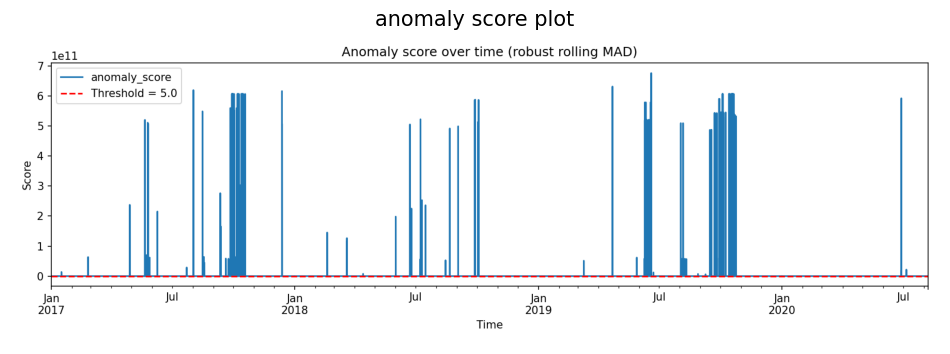

In [16]:
img = mpimg.imread(plot_path)
plt.figure(figsize=(12,6))
plt.imshow(img)
plt.axis("off")
plt.title("anomaly score plot", fontsize = 15)
plt.show()